In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-08-01 23:11:16.995845: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-01 23:11:17.000872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 23:11:17.000887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

In [2]:
#creating a data frame
df = pd.read_csv("Updated//full_dataset_fakenewsnet_cleaned_using_nltk.csv")

In [3]:
df = df[df['fulltext'].notna()]

In [4]:
## Shuffling the rows
df = df.sample(frac=1)

In [5]:
X=df[['fulltext']]
y=df[['class']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [7]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

2022-08-01 23:13:08.806490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 23:13:08.806786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-08-01 23:13:08.807018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [8]:
MAX_SEQ_LEN=256
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
#Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [10]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

In [11]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

# test_sentences=X_test.fulltext.values
# test_y = y_test.values
# test_inputs=create_input_array(test_sentences)

100%|██████████| 16289/16289 [02:08<00:00, 126.80it/s]


In [12]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_LSTM_BERT_PRETRAINED_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})


In [14]:
y_pred=lstm_model.predict(train_inputs)
ytrue = y_train.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
510/510 [==============================] - 1036s 2s/step


In [15]:
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9441340782122905
precision = 0.9209464909922022
recall = 0.8475624845335313
f1score = 0.8827319587628866
[[11954   294]
 [  616  3425]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12248
           1       0.92      0.85      0.88      4041

    accuracy                           0.94     16289
   macro avg       0.94      0.91      0.92     16289
weighted avg       0.94      0.94      0.94     16289



In [16]:
train_df=pd.concat([X_train, y_train], axis=1)

In [17]:
#combining predictions with truth class labels in test_filtered dataframe
train_df.insert(len(train_df.columns),'pred',y_pred2)
train_df.head(2)

,fulltext,class,pred
12661,‘Twin Peaks’ Teaser Offers First New Footage of the Upcoming Revival — Watch.Return to the red room.\n\nWe still don’t know what’s in store for us when “Twin Peaks” makes its long-awaited return n...,0,0
5995,How Much Is Jon Batiste's Net Worth? His Sources Of Income And Achievements.Jon Batiste is one of the prominent American musicians and is cherishing his successful professional career so far. The ...,0,0


In [18]:
#misclassified samples
misclassified_df = df.loc[train_df[train_df['class']!=train_df['pred']].index, :]  # works
misclassified_df.shape

(910, 10)

In [19]:
misclassified_df.insert(0, 'New_ID', range(1, 1 + len(misclassified_df)))


,New_ID,url,text,title,authors,num_images,domain,Category,class,fulltext,cleantext
16679,1,www.dailymail.co.uk/tvshowbiz/kylie_jenner/index.html,LATEST KYLIE JENNER AND STORMI NEWS AND INSTAGRAM UPDATES\n\nThe new Rapunzel! Kendall Jenner reveals just how long her red hair extensions are as she poses for smoldering selfies in a bathroom Sh...,"Kylie Jenner: Latest news, views, gossip, photos and video",[],512,dailymail,Gossips,1,"Kylie Jenner: Latest news, views, gossip, photos and video.LATEST KYLIE JENNER AND STORMI NEWS AND INSTAGRAM UPDATES\n\nThe new Rapunzel! Kendall Jenner reveals just how long her red hair extensio...",kylie jenner latest news view gossip photo video latest kylie jenner stormi news instagram update new rapunzel kendall jenner reveals long red hair extension pose smoldering selfies bathroom model...
9993,2,https://www.tmz.com/2017/06/16/jennifer-lopez-alex-rodriguez-bikini-yacht-france/,"Bad news for the rest of us -- Jennifer Lopez and Alex Rodriguez are getting even more bronzed and beautiful than they already are.\n\nThe couple jetted off to the South of France, and boarded a y...",J Lo and A-Rod Compare Tan Lines in South of France,[],30,tmz,Gossips,0,J Lo and A-Rod Compare Tan Lines in South of France.Bad news for the rest of us -- Jennifer Lopez and Alex Rodriguez are getting even more bronzed and beautiful than they already are.\n\nThe coupl...,rod compare tan line south france bad news rest jennifer lopez alex rodriguez getting bronzed beautiful couple jetted south france boarded yacht antibes day sun wore sexy tiny crochet monokini rod...
17551,3,www.dailymail.co.uk/tvshowbiz/article-4936794/Caitlyn-Jenner-takes-plane-spin-LA.html,"Kim Kardashian called her a 'liar' and 'shady' during a teaser for this Sunday's Keeping Up With The Kardashians.\n\nBut on Friday, Caitlyn Jenner brushed off all the drama as she took her Beechcr...",Caitlyn Jenner takes her plane out for a spin in LA,['Dailymail.Com Reporter'],469,dailymail,Gossips,1,"Caitlyn Jenner takes her plane out for a spin in LA.Kim Kardashian called her a 'liar' and 'shady' during a teaser for this Sunday's Keeping Up With The Kardashians.\n\nBut on Friday, Caitlyn Jenn...",caitlyn jenner take plane spin kim kardashian called liar shady teaser sunday keeping kardashians friday caitlyn jenner brushed drama took beechcraft baron plane spin van nuys california year old ...
9507,4,https://www.cosmopolitan.com/entertainment/celebs/a19390157/khloe-kardashian-thin-af-photo-tips/,"This content is imported from {embed-name}. You may be able to find the same content in another format, or you may be able to find more information, at their web site.\n\nI'm sorry to report that ...","Khloe Kardashian Shares Photo Tips to Make You Look ""Thin AF."" Oh, Khloe.","['Laura Beck', 'Laura Beck Is A Los Angeles-Based Tv Writer', 'Frequent Contributor To Cosmopolitan.Com', 'Her Work Has Appeared In The New York Times', 'New Yorker', 'Jezebel', 'The Village Voice.']",4,cosmopolitan,Gossips,0,"Khloe Kardashian Shares Photo Tips to Make You Look ""Thin AF."" Oh, Khloe..This content is imported from {embed-name}. You may be able to find the same content in another format, or you may be able...",khloe kardashian share photo tip look khloe content imported embed able content format able information web site sorry report latest post khloe kardashian khloe app looking photo heavy sigh fat si...
18556,5,www.usmagazine.com/entertainment/news/kuwtk-recap-kris-jenner-is-in-denial-about-o-j-simpsons-parole/,"Drama all around! The Sunday, January 21, episode of Keeping Up With the Kardashians saw more friction between Kourtney Kardashian and Scott Disick and it also featured a brief but chilling moment...",'KUWTK' Recap: Kris Jenner Is in Denial About O.J. Simpson's Parole,['Cait Raft'],9,usmagazine,Gossips,1,"'KUWTK' Recap: Kris Jenner Is in Denial About O.J. Simpson's Parole.Drama all around! The Sunday, January 21, episode of Keeping Up With the Kardashians saw more fricti

In [21]:
misclassified_df['class'].value_counts()

1    616
0    294
Name: class, dtype: int64

In [23]:
df_domain_misclassfd_count=misclassified_df.pivot_table(index='domain',columns = 'class', values = 'New_ID', 
                                          aggfunc='count').fillna(0).astype(int)

In [24]:
wrongpred_real_domain=df_domain_misclassfd_count[0].sort_values(ascending=False).head(15)
wrongpred_fake_domain=df_domain_misclassfd_count[1].sort_values(ascending=False).head(15)

<AxesSubplot:xlabel='domain'>

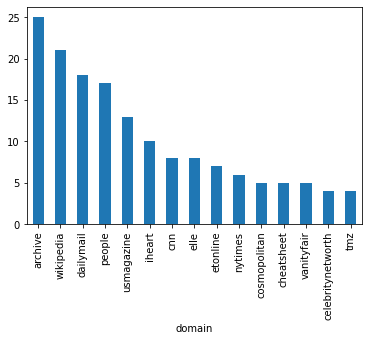

In [25]:
wrongpred_real_domain.plot(kind='bar')

<AxesSubplot:xlabel='domain'>

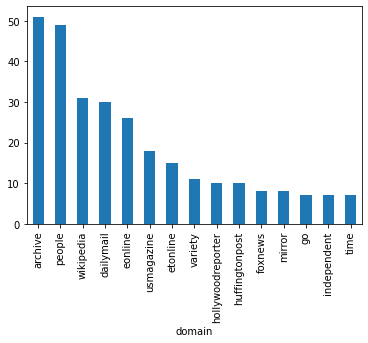

In [26]:
wrongpred_fake_domain.plot(kind='bar')